<a href="https://colab.research.google.com/github/bolaris-sage/shark-research/blob/main/shark-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This analysis delves into the behavior of a female great white shark around Guadalupe Island, a critical habitat for these majestic creatures and a key area for marine conservation. From October 15th to 23rd, 2017, we collected data using various sensors, offering a window into the shark's world. Our goal is to uncover patterns in depth, environmental conditions, and movement, and to understand how these factors interplay. This study not only provides insights into the daily life of a great white shark but also contributes to broader marine conservation efforts. Key questions include the impact of environmental conditions on the shark's depth and activity levels. Interactive visualizations will guide us through this exploration.


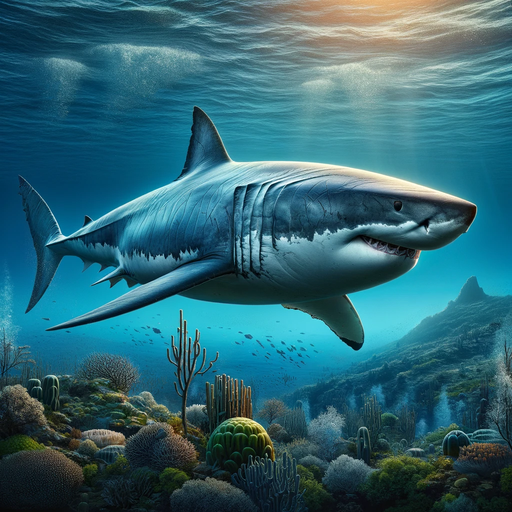

## Data Overview

### CEFAS 1 Female 4.5
- **Deployment Duration**: October 15, 2017 - October 23, 2017
- **Tag ID**: A14243
- **Firmware**: Version 3, Build Level 70
- **Sensors Count**: 5
- **Sensors**:
  - *Pressure*: Measures depth, crucial for understanding diving behavior.
  - *Temperature*: Helps correlate the shark's behavior with environmental conditions.
  - *3-axis accelerometer*: Tracks movement, vital for assessing energy expenditure and detailed movement patterns.
- **Accelerometer Attachment**: [Details if known, or state 'Unknown']
- **Logging Rate**: 1 per second
- **Resolution**: 12 bits
- **Pressure Range**: 50 units
- **G range selected**: 2g (measures acceleration)
- **Wet dry logging**: Inhibited (prevents logging when dry)
- **Logging of Dive data**: Active
- **Dive Termination Criteria**: 1.5% percentage, 7.5m depth

The dataset includes time-stamped measurements of pressure, temperature, and tri-axial acceleration, offering a high-resolution view into the shark's movement and behavior in its natural habitat.


# Analysis

In this section, we will perform a comprehensive analysis of the shark's behavior. Our approach includes data cleaning, exploratory data analysis, and time-series analysis to identify patterns in the shark's movement and environmental interactions. Key focus areas include assessing diurnal patterns, depth preferences, and responses to environmental changes.


## Import Libraries

In [1]:
# Install (if needed)
!pip install astral --quiet
!pip install ipywidgets --quiet

# Import necessary libraries
from datetime import date, datetime, timedelta
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pytz import timezone
from astral import LocationInfo
from astral.sun import sun, dawn, dusk
from matplotlib.colors import LinearSegmentedColormap
import ipywidgets as widgets
from IPython.display import display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00


## Data Loading

In [2]:
# This section checks if the notebook is running on Google Colab and sets the base path accordingly.
running_on_colab = 'google.colab' in sys.modules

if running_on_colab:
    # Google Colab specific imports
    from google.colab import auth, drive

    # Authenticate and mount the drive
    auth.authenticate_user()
    drive.mount('/content/drive')

    # Set the base path for data on Google Drive
    base_path = '/content/drive/MyDrive/shark-data/'
else:
    # Set the base path for local data
    base_path = 'C:/shared/shark-data/'

# Now you can load your data using the base path
data_file_path = os.path.join(base_path, 'A14243_23-10-2017.csv')

# Load the data
data = pd.read_csv(data_file_path, skiprows=59)

# Check if data loaded correctly
if data.empty:
    raise ValueError("Data failed to load or is empty.")

Mounted at /content/drive


## Data Cleaning

Before diving into the analysis, it's crucial to ensure our data is clean and reliable. This step involves removing inconsistencies, handling missing values, and ensuring the data is correctly formatted. Our aim is to create a solid foundation for accurate and meaningful analysis. We'll start by inspecting the data for any anomalies and proceed to clean it for further exploration.


In [3]:
import numpy as np

# Convert 'Time Stamp' to datetime and drop rows with invalid dates
initial_count = data.shape[0]
data['Time Stamp'] = pd.to_datetime(data['Time Stamp'], format='%d/%m/%y %H:%M', errors='coerce')

valid_mask = data['Time Stamp'].notna() & data['Pressure'].notna() & (data['Pressure'] != np.inf) & data['Temp'].notna() & (data['Temp'] != np.inf) & (data['Temp'] != -np.inf)

# Keeping a copy of the dropped data for potential review or audit of the cleaning process
dropped_data = data[~valid_mask]

# Filter for valid data
data = data[valid_mask]

# Summary of dropped data
dropped_due_to_invalid_values = len(dropped_data)

print(f"Total initial events: {initial_count}")
print(f"Dropped due to invalid values: {dropped_due_to_invalid_values}")
print(f"Remaining events after cleaning: {data.shape[0]}")

# Display a sample of dropped data for verification
#print("Sample of data dropped:")
#print(dropped_data.head())

Total initial events: 700624
Dropped due to invalid values: 4
Remaining events after cleaning: 700620


## Data Transformation

#### Overall Dynamic Body Acceleration (ODBA)
**Description**: A proxy for the animal's energy expenditure, reflecting its locomotor activity.
**Calculation**: Sum of the absolute differences between the raw and smoothed (rolling mean) accelerations across the `X`, `Y`, and `Z` axes.
$$
ODBA = |X_{dyn}| + |Y_{dyn}| + |Z_{dyn}|
$$
#### Vectorial Dynamic Body Acceleration (VeDBA)
**Description**: Represents the vector magnitude of the dynamic acceleration, capturing the total dynamic movement across all three spatial axes.
**Calculation**: Square root of the sum of the squared dynamic body accelerations for each axis.
$$
VeDBA = \sqrt{X_{dyn}^2 + Y_{dyn}^2 + Z_{dyn}^2}
$$
#### Movement Variation
**Description**: Indicates the change in acceleration from one time point to the next, capturing how much the acceleration is varying over time.
**Calculation**: Absolute sum of the differences in dynamic acceleration from one time point to the next across all three axes.
$$
Movement\ Variation = |X_{i+1} - X_i| + |Y_{i+1} - Y_i| + |Z_{i+1} - Z_i|
$$
#### Energy
**Description**: Quantifies the sum of the squares of the accelerations, associated with the potential and kinetic energy of the animal's movement.
**Calculation**: Sum of squares of the raw accelerations across the `X`, `Y`, and `Z` axes.
$$
Energy = (X_i^2 + Y_i^2 + Z_i^2)
$$
#### Pitch
**Description**: The orientation angle of the animal in the forward and backward direction, which can indicate climbing or descending behavior.
**Calculation**: Arctangent of the negative dynamic `X` acceleration divided by the square root of the sum of the squares of the dynamic `Y` and `Z` accelerations, converted from radians to degrees.
$$
Pitch = \tan^{-1}\left(\frac{-X_i}{\sqrt{Y_i^2 + Z_i^2}}\right) \times \frac{180}{\pi}
$$
#### Roll
**Description**: The orientation angle of the animal around its longitudinal axis, which can indicate banking or turning behavior.
**Calculation**: Two-argument arctangent of the dynamic `Y` and `Z` accelerations, converted from radians to degrees.
$$
Roll = \text{atan2}(Y_i, Z_i) \times \frac{180}{\pi}
$$

In [4]:
# Ensure data is a copy to avoid SettingWithCopyWarning
data = data.copy()

# Calculate rolling mean for smoothing
rolling_mean = data[['X Axis', 'Y Axis', 'Z Axis']].rolling(window=5).mean()

# Calculate dynamic acceleration (subtraction of static acceleration, which is the rolling mean)
dynamic_acceleration = data[['X Axis', 'Y Axis', 'Z Axis']] - rolling_mean

# Calculate ODBA
data['ODBA'] = dynamic_acceleration.abs().sum(axis=1)

# Calculate VeDBA
data['VeDBA'] = np.sqrt((dynamic_acceleration**2).sum(axis=1))

# Calculate Movement Variation
data['Movement Variation'] = dynamic_acceleration.diff().abs().sum(axis=1)

# Calculate Energy
data['Energy'] = (data[['X Axis', 'Y Axis', 'Z Axis']]**2).sum(axis=1)

# Calculate Pitch and Roll in degrees
data['Pitch'] = np.arctan2(-dynamic_acceleration['X Axis'],
                           np.sqrt(dynamic_acceleration['Y Axis']**2 +
                                   dynamic_acceleration['Z Axis']**2)) * (180 / np.pi)

data['Roll'] = np.arctan2(dynamic_acceleration['Y Axis'],
                          dynamic_acceleration['Z Axis']) * (180 / np.pi)

# Shift the data frame by 1 to align the movement variation with the correct timestamp
data['Movement Variation'] = data['Movement Variation'].shift(-1)

# Drop the last row which will have NaN values due to the shift operation
data = data[:-1]


### Calculating Day-Night Cycle Times

In [5]:
# Define the location and timezone for sunrise/sunset calculations
guadalupe_coords = {'latitude': 29.020879, 'longitude': -118.273103}
city = LocationInfo('Ensenada', 'Mexico', 'America/Tijuana', guadalupe_coords['latitude'], guadalupe_coords['longitude'])
local_tz = timezone('America/Tijuana')

# Cache the observer since it doesn't change
observer = city.observer

# Custom function to calculate sunrise, sunset, and nautical twilight
def calculate_sun_cycles(current_date):
    sun_times = sun(observer, date=current_date, tzinfo=local_tz)
    nautical_start = dawn(observer, date=current_date, tzinfo=local_tz)
    nautical_end = dusk(observer, date=current_date, tzinfo=local_tz)

    return {
        'sunrise': sun_times['sunrise'].replace(tzinfo=None),
        'sunset': sun_times['sunset'].replace(tzinfo=None),
        'nautical_twilight_start': nautical_start.replace(tzinfo=None),
        'nautical_twilight_end': nautical_end.replace(tzinfo=None)
    }

# Custom function to plot day, night, and nautical twilight bands
def plot_day_night_bands(sun_cycles, ax, include_twilight=True):
    # Iterate over the sun cycles with index for labeling
    for idx, (current_date, times) in enumerate(sun_cycles.items()):
        # Extract the sunrise and sunset times
        sunrise, sunset = times['sunrise'], times['sunset']

        # Plot day band, label only on first cycle
        ax.axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15, label='Day' if idx == 0 else "")

        # Include twilight bands, label only on first cycle
        if include_twilight:
            nautical_start, nautical_end = times['nautical_twilight_start'], times['nautical_twilight_end']
            ax.axvspan(nautical_start, sunrise, color='orange', alpha=0.1, label='Twilight' if idx == 0 else "")
            ax.axvspan(sunset, nautical_end, color='orange', alpha=0.1)

        # Plot night band, label only on first cycle, avoid plotting for the last day
        if idx < len(sun_cycles) - 1:
            next_day_sunrise = sun_cycles[date.fromordinal(current_date.toordinal() + 1)]['sunrise']
            ax.axvspan(sunset, next_day_sunrise, color='black', alpha=0.1, label='Night' if idx == 0 else "")

# Use the data to calculate sun cycles (this assumes 'data' is a pre-existing DataFrame)
data['Date'] = data['Time Stamp'].dt.date
sun_cycles = {current_date: calculate_sun_cycles(current_date) for current_date in data['Date'].unique()}

## Exploratory Data Analysis

### Depth and Tempature Analysis

In this section, we focus on the depth data recorded by the pressure sensor. Depth analysis will reveal the shark's diving patterns and preferences. By examining depth over time, we can infer behaviors like hunting, resting, and exploration. We'll also look for any diurnal patterns or responses to environmental changes that might influence these depth preferences.


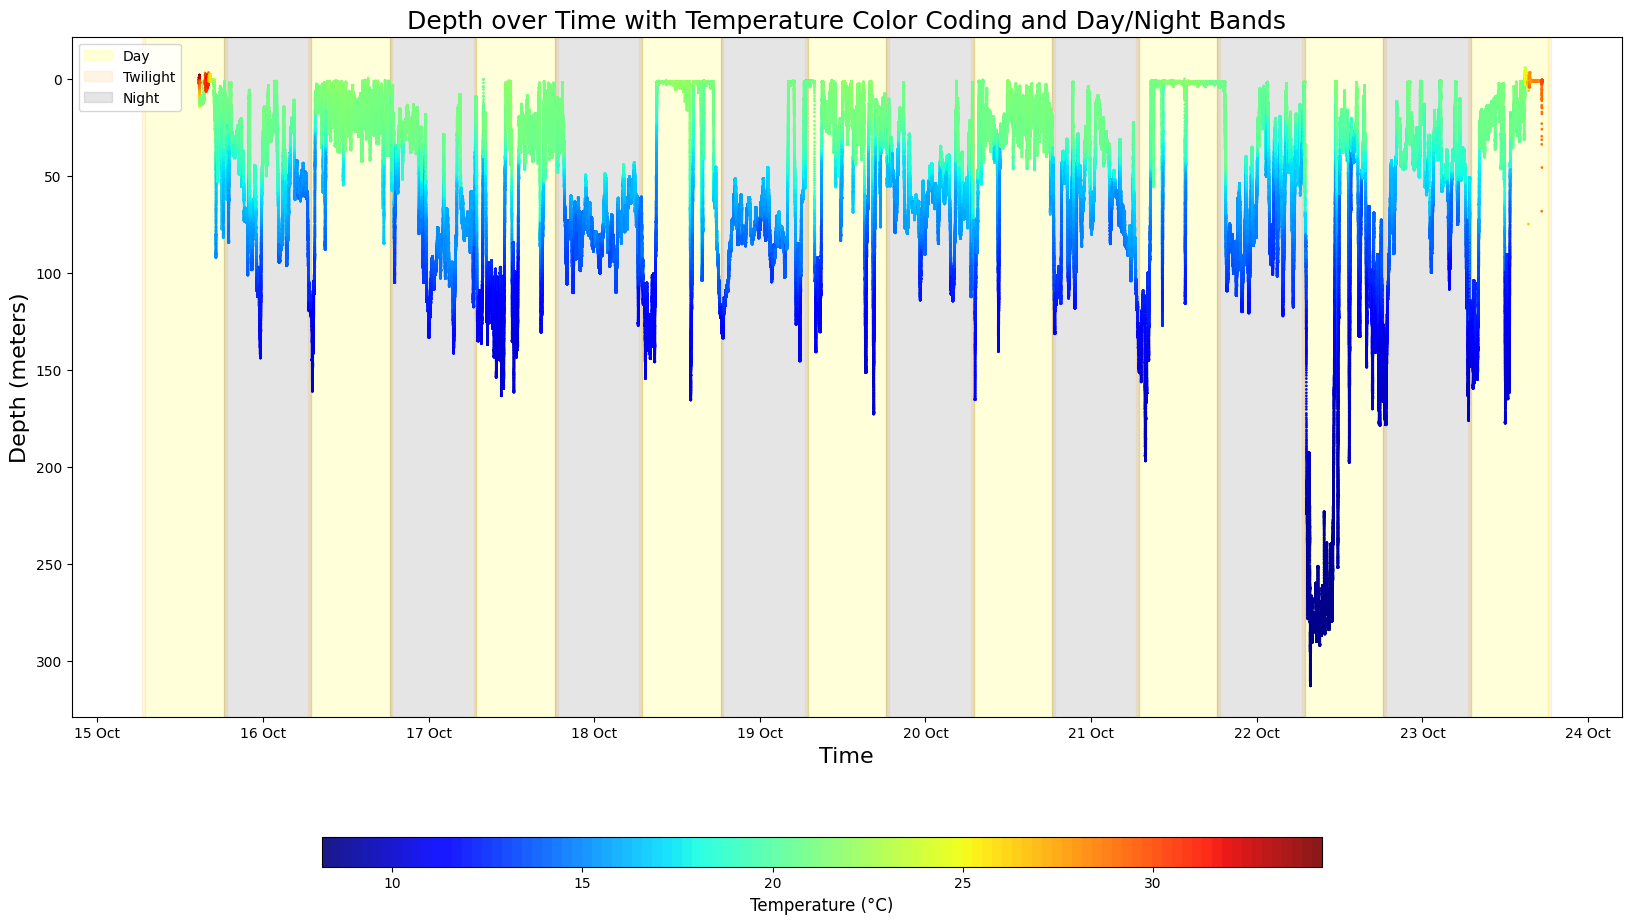

In [16]:
# Set plot titles and labels
plt.figure(figsize=(20, 10))
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (meters)', fontsize=16)
plt.title('Depth over Time with Temperature Color Coding and Day/Night Bands', fontsize=18)

# Plot day-night bands
plot_day_night_bands(sun_cycles, plt.gca())

# Use a predefined colormap
cmap = plt.get_cmap('jet', 100)
norm = plt.Normalize(vmin=data['Temp'].min(), vmax=data['Temp'].max())

# Plot depth data against time, colored by temperature
sc = plt.scatter(data['Time Stamp'], data['Pressure'], c=data['Temp'], cmap=cmap, norm=norm, s=1, alpha=0.9)

# Make increased depth down
plt.gca().invert_yaxis()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Extract handles and labels for the legend from the current axis
handles, labels = plt.gca().get_legend_handles_labels()

# Create legend from handles and labels
plt.legend(handles, labels, loc='upper left')

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
colorbar_axes = plt.gcf().add_axes([0.25, 0.05, 0.5, 0.03])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('Temperature (°C)', fontsize=12)

# Show the plot
plt.show()

## Movement and Acceleration Analysis

Next, we'll analyze the shark's movement using the data from the 3-axis accelerometer. This analysis will help us understand the shark's activity levels and energy expenditure. We aim to distinguish different types of movements such as swimming speed, sudden turns, or resting periods. This will give us insights into the shark's behavior and how it interacts with its environment.


### ODBA over Time with Day/Night Bands
The graph shows sharks' Overall Dynamic Body Acceleration (ODBA) over time, marked with day (yellow) and night (black) bands.

In [20]:
# Function to update the plot based on the selected axis
def update_plot(axis_name):
  # Set plot size, titles and labels
  plt.figure(figsize=(20, 10))
  plt.xlabel('Time', fontsize=14)
  plt.ylabel(axis_name, fontsize=14)
  plt.title(f'{axis_name} Over Time with Day/Night Bands', fontsize=16)

  # Plot day-night bands
  plot_day_night_bands(sun_cycles, plt.gca())

  resampled_data = data.resample('min', on='Time Stamp').mean(numeric_only=True)

  # Calculate the moving average of ODBA with a window size
  window_size = 5
  odba_moving_average = resampled_data[axis_name].rolling(window=window_size).mean()

  # Plot the moving average ODBA line
  plt.plot(resampled_data.index, odba_moving_average, color='grey', alpha=0.5, label='Moving Average')

  cmap = plt.get_cmap('gist_rainbow', 100).reversed()
  lower_percentile = 2
  upper_percentile = 98
  lower_bound = data[axis_name].quantile(lower_percentile / 100)
  upper_bound = data[axis_name].quantile(upper_percentile / 100)
  norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

  # Scatter plot for ODBA values over time
  sc = plt.scatter(resampled_data.index, resampled_data[axis_name], s=5, alpha=0.9,
                        c=resampled_data[axis_name], cmap=cmap, norm=norm, edgecolor='none', label=axis_name)

  # Format the x-axis
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

  # Extract handles and labels for the legend from the current axis
  handles, labels = plt.gca().get_legend_handles_labels()

  # Create legend from handles and labels
  plt.legend(handles, labels, loc='upper left')

  # Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
  plt.subplots_adjust(bottom=0.20)

  # Adjust the position of the colorbar
  colorbar_axes = plt.gcf().add_axes([0.25, 0.05, 0.5, 0.03])

  # Create the colorbar with the specified axes and orientation
  cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

  # Set the label for the colorbar
  cbar.set_label('ODBA (g)', fontsize=14)

  # Show the plot
  plt.show()


# Dropdown widget for axis selection
axis_dropdown = widgets.Dropdown(
    options=['X Axis', 'Y Axis', 'Z Axis', 'ODBA', 'VeDBA', 'Movement Variation', 'Energy', 'Pitch', 'Roll'],
    value='ODBA',
    description='Color by:',
)

# Widget interaction
widgets.interact(update_plot, axis_name=axis_dropdown)

interactive(children=(Dropdown(description='Color by:', index=3, options=('X Axis', 'Y Axis', 'Z Axis', 'ODBA'…

<function __main__.update_plot(axis_name)>

### Depth over Time with ODBA Color Coding

### Axis Values Over Time with ODBA Color Coding

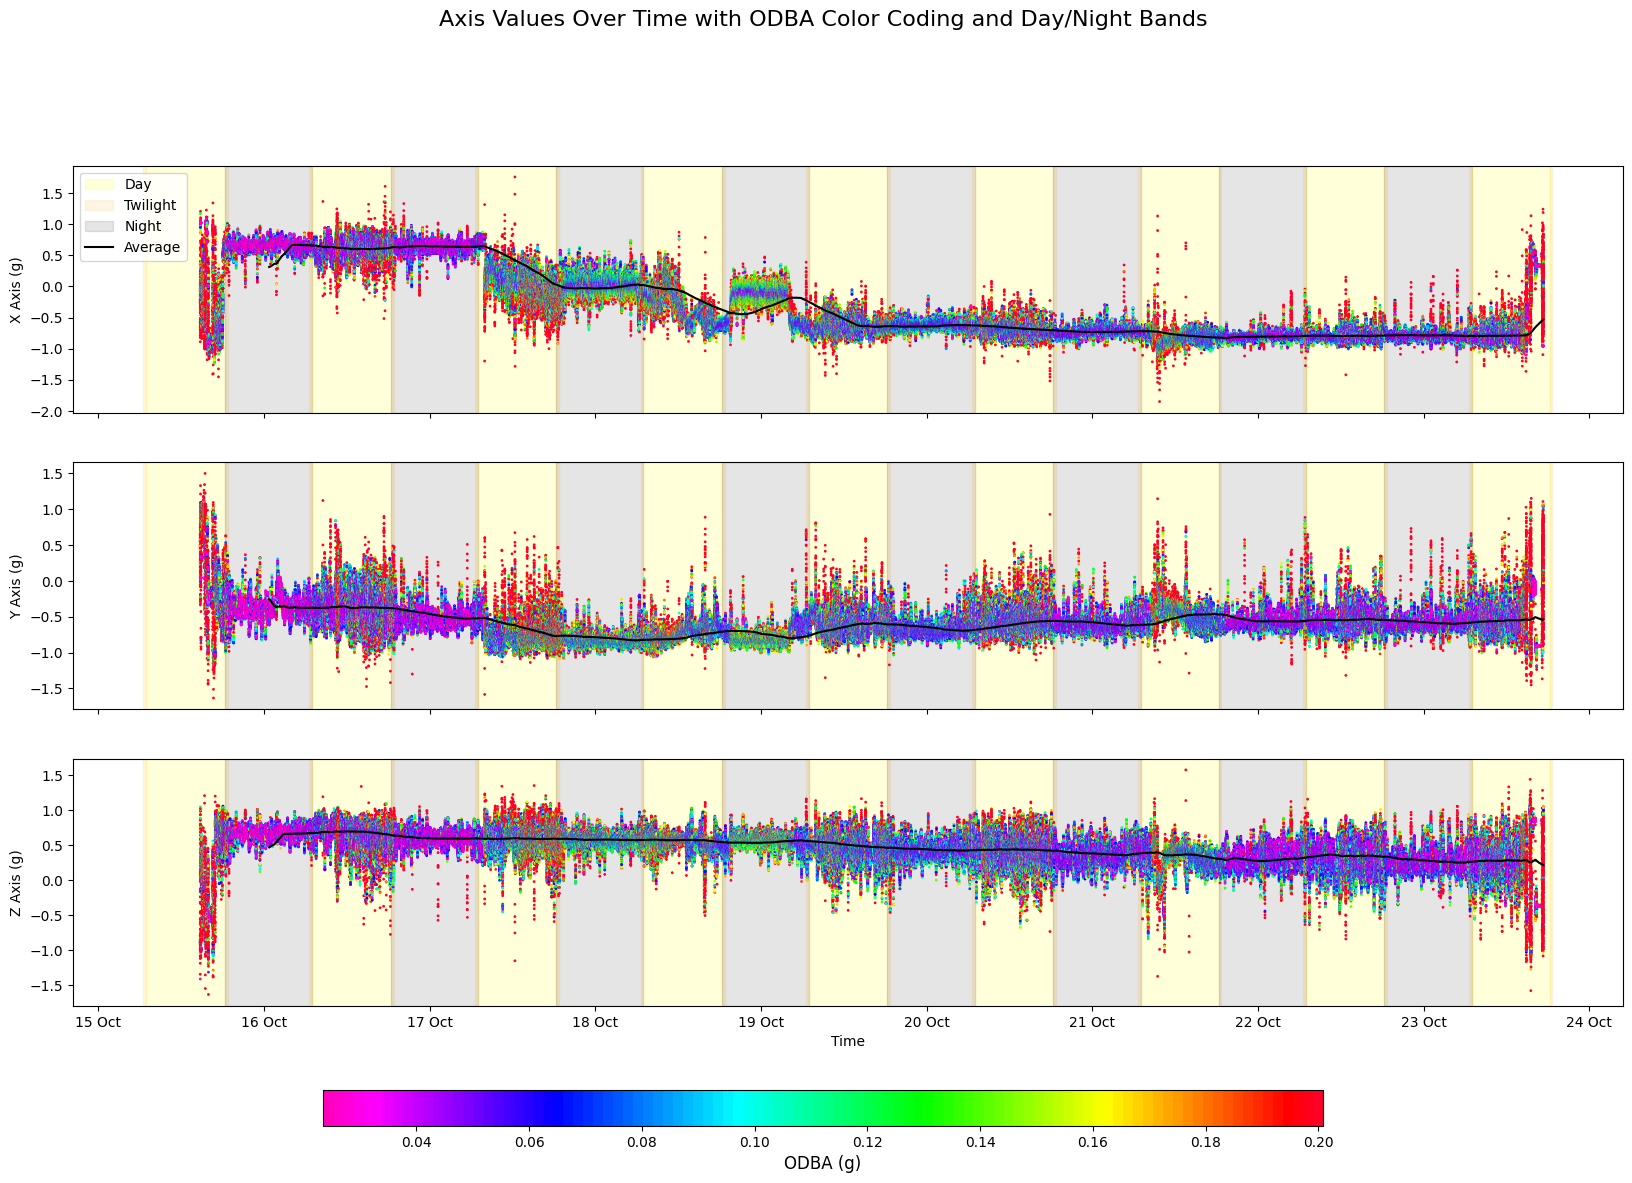

In [8]:
# Create a subplot layout
fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharex=True)

# Store the day/night patches for the legend
day_patch = None
twilight_patch = None
night_patch = None

cmap = plt.get_cmap('gist_rainbow_r', 100)
lower_percentile = 2
upper_percentile = 98

resampled_data = data.resample('min', on='Time Stamp').mean(numeric_only=True)

lower_bound = resampled_data['ODBA'].quantile(lower_percentile / 100)
upper_bound = resampled_data['ODBA'].quantile(upper_percentile / 100)
norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

for i, axis in enumerate(['X Axis', 'Y Axis', 'Z Axis']):
    # Call plot_day_night_bands for each subplot
    plot_day_night_bands(sun_cycles, axs[i])

    # Scatter plot for color-coded ODBA data
    sc = axs[i].scatter(data['Time Stamp'], data[axis], c=data['ODBA'], cmap=cmap, norm=norm, s=1, alpha=1.0)
    axs[i].set_ylabel(f'{axis} (g)')

    window_size = 600
    # Calculate the moving average of the current axis
    moving_average = resampled_data[axis].rolling(window=window_size).mean()
    # Plot the moving average line
    axs[i].plot(resampled_data.index, moving_average, color='black', alpha=1, label='Average')

    # Format the x-axis
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))

# After plotting on all subplots, extract handles and labels for the legend from the last axis
handles, labels = axs[-1].get_legend_handles_labels()

# Create legend from handles and labels and add it to the first subplot
axs[0].legend(handles, labels, loc='upper left')

# Set common X-Axis properties
axs[-1].set_xlabel('Time')

# Set the title for the entire figure
fig.suptitle('Axis Values Over Time with ODBA Color Coding and Day/Night Bands', fontsize=16)

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.20)

# Adjust the position of the colorbar
# These values are fractions of the figure size. (left, bottom, width, height)
colorbar_axes = fig.add_axes([0.25, 0.05, 0.5, 0.03])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')
cbar.set_label('ODBA (g)', fontsize=12)

# Adjust layout
fig.subplots_adjust(bottom=0.15, top=0.85)

# Show the plot
plt.show()

### Depth over Time with Axis Value or Summary Statistics Color Coding
Select the X, Y, or Z axis or a summary Statistic for color-coding via a dropdown menu.
Automatically update the plot based on the axis chosen.

In [17]:
# Function to update the plot based on the selected axis
def update_plot(axis_name):
    fig, ax = plt.subplots(figsize=(20, 10))
    plot_day_night_bands(sun_cycles, ax)

    # Dynamically adjusting the color range based on selected axis
    lower_bound = data[axis_name].quantile(0.02)
    upper_bound = data[axis_name].quantile(0.98)
    norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

    # Scatter plot
    sc = plt.scatter(data['Time Stamp'], data['Pressure'], c=data[axis_name],
                     cmap='jet', norm=norm, s=1, alpha=1.0)

    # Enhancing the plot
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

    # Plot titles and labels
    plt.title(f'Depth over Time with {axis_name} Color Coding and Day/Night Bands', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Depth (meters)', fontsize=12)

    # Extract handles and labels for the legend from the current axis
    handles, labels = plt.gca().get_legend_handles_labels()

    # Create legend from handles and labels
    plt.legend(handles, labels, loc='upper left')

    # Adding colorbar
    colorbar_axes = plt.gcf().add_axes([0.25, 0.05, 0.5, 0.03])
    cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')
    cbar.set_label(f'{axis_name}', fontsize=12)

    plt.show()

# Dropdown widget for axis selection
axis_dropdown = widgets.Dropdown(
    options=['X Axis', 'Y Axis', 'Z Axis', 'ODBA', 'VeDBA', 'Movement Variation', 'Energy', 'Pitch', 'Roll'],
    value='X Axis',
    description='Color by:',
)

# Widget interaction
widgets.interact(update_plot, axis_name=axis_dropdown)

interactive(children=(Dropdown(description='Color by:', options=('X Axis', 'Y Axis', 'Z Axis', 'ODBA', 'VeDBA'…

<function __main__.update_plot(axis_name)>

## Unsupervised Learning Analysis of Accelerometer Data
In this section, we will apply unsupervised learning techniques to classify segments of the accelerometer data (x, y, z axes). Our goal is to identify distinct patterns in the data that may correspond to different shark behaviors. We will use clustering algorithms to group similar data points and then analyze these clusters to infer possible behaviors.


In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

# Make a copy of the DataFrame to work with
data_processed = data.copy()

# Print column names to check the correct column name
print(data_processed.columns)

# Set 'Time Stamp' as the index of the DataFrame
data_processed.set_index('Time Stamp', inplace=True)

# Calculate rolling mean for each axis.
# Use min_periods=1 to ensure we get a value even if the window is not full
# Since 'Time Stamp' is now the index, we access it with data_processed.index
data_processed['rolling_mean_x'] = data_processed['X Axis'].rolling('1H', min_periods=1).mean()
data_processed['rolling_mean_y'] = data_processed['Y Axis'].rolling('1H', min_periods=1).mean()
data_processed['rolling_mean_z'] = data_processed['Z Axis'].rolling('1H', min_periods=1).mean()

# Calculate the deviation from the rolling mean
data_processed['X Axis deviation'] = data_processed['X Axis'] - data_processed['rolling_mean_x']
data_processed['Y Axis deviation'] = data_processed['Y Axis'] - data_processed['rolling_mean_y']
data_processed['Z Axis deviation'] = data_processed['Z Axis'] - data_processed['rolling_mean_z']

# Drop rows with NaN values that result from rolling mean
# This step will avoid dropping all data
data_processed.dropna(subset=['X Axis deviation', 'Y Axis deviation', 'Z Axis deviation'], inplace=True)

# Check if data is empty after dropping NaN values
if data_processed.empty:
    raise ValueError(f"All data has been dropped after removing NaN values. Non-NaN before drop: {non_nan_before_drop}, after drop: {non_nan_after_drop}.")

# Parameters for windowing
window_size = 50  # Number of readings in a window
overlap = 25      # Number of readings to overlap between windows

# Function to create windows and extract features from deviations
def create_windows(df, window_size, overlap):
    feature_list = []
    for start in range(0, df.shape[0] - window_size, window_size - overlap):
        end = start + window_size
        window = df.iloc[start:end]
        features = {
            'mean_x_dev': window['X Axis deviation'].mean(),
            'mean_y_dev': window['Y Axis deviation'].mean(),
            'mean_z_dev': window['Z Axis deviation'].mean(),
            'std_x_dev': window['X Axis deviation'].std(),
            'std_y_dev': window['Y Axis deviation'].std(),
            'std_z_dev': window['Z Axis deviation'].std(),
            # Add other statistical features as necessary
        }
        feature_list.append(features)
    return pd.DataFrame(feature_list)

# Create windows from deviations
windowed_data = create_windows(data_processed, window_size, overlap)

# Normalize the feature data
scaler = StandardScaler()
windowed_data_scaled = scaler.fit_transform(windowed_data)

# Apply K-Means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
clusters = kmeans.fit_predict(windowed_data_scaled)

# Add cluster assignments back to the original data
for i, start in enumerate(range(0, data_processed.shape[0] - window_size, window_size - overlap)):
    end = start + window_size
    if end > data_processed.shape[0]:
        end = data_processed.shape[0]
    data_processed.loc[start:end, 'cluster'] = clusters[i]

Index(['Time Stamp', 'Pressure', 'Temp', 'X Axis', 'Y Axis', 'Z Axis',
       'Unnamed: 6', 'Unnamed: 7', 'ODBA', 'VeDBA', 'Movement Variation',
       'Energy', 'Pitch', 'Roll', 'Date'],
      dtype='object')


<ipython-input-10-80ca134658f2>:74: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data_processed.loc[start:end, 'cluster'] = clusters[i]
<ipython-input-10-80ca134658f2>:74: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data_processed.loc[start:end, 'cluster'] = clusters[i]


In [11]:
# Calculate the centroids of each cluster
centroids = kmeans.cluster_centers_

# Create a DataFrame for cluster statistics
cluster_stats = pd.DataFrame(centroids, columns=['mean_x_dev', 'mean_y_dev', 'mean_z_dev', 'std_x_dev', 'std_y_dev', 'std_z_dev'])

# Display the cluster centroids
print("Cluster Centroids:")
print(cluster_stats)

# Additional descriptive statistics for each cluster
for i in range(n_clusters):
    print(f"\nCluster {i} statistics:")
    cluster_data = windowed_data[(clusters == i)]
    print(cluster_data.describe())


Cluster Centroids:
   mean_x_dev  mean_y_dev  mean_z_dev  std_x_dev  std_y_dev  std_z_dev
0    0.065276   -0.076039    0.011143   1.006285  -0.241149  -0.335947
1   -0.033498   -0.516258   -0.506162  -0.526996  -0.404947  -0.277653
2    0.028677    0.197338    0.015650   0.711664   1.424936   1.640376
3   -0.035785    0.683558    0.769057  -0.406266  -0.095300  -0.255168
4    0.453707    1.549997    0.315843   3.625929   4.559018   3.638070

Cluster 0 statistics:
        mean_x_dev   mean_y_dev   mean_z_dev    std_x_dev    std_y_dev  \
count  5154.000000  5154.000000  5154.000000  5154.000000  5154.000000   
mean      0.008427    -0.012526     0.001036     0.109369     0.045007   
std       0.116770     0.070701     0.071891     0.028756     0.022136   
min      -0.678819    -1.511134    -0.625122     0.046870     0.013016   
25%      -0.041866    -0.044021    -0.039085     0.092202     0.030197   
50%       0.002492    -0.012415    -0.000741     0.104124     0.038404   
75%       0.04

<ipython-input-12-5c3b609664d1>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n_clusters)


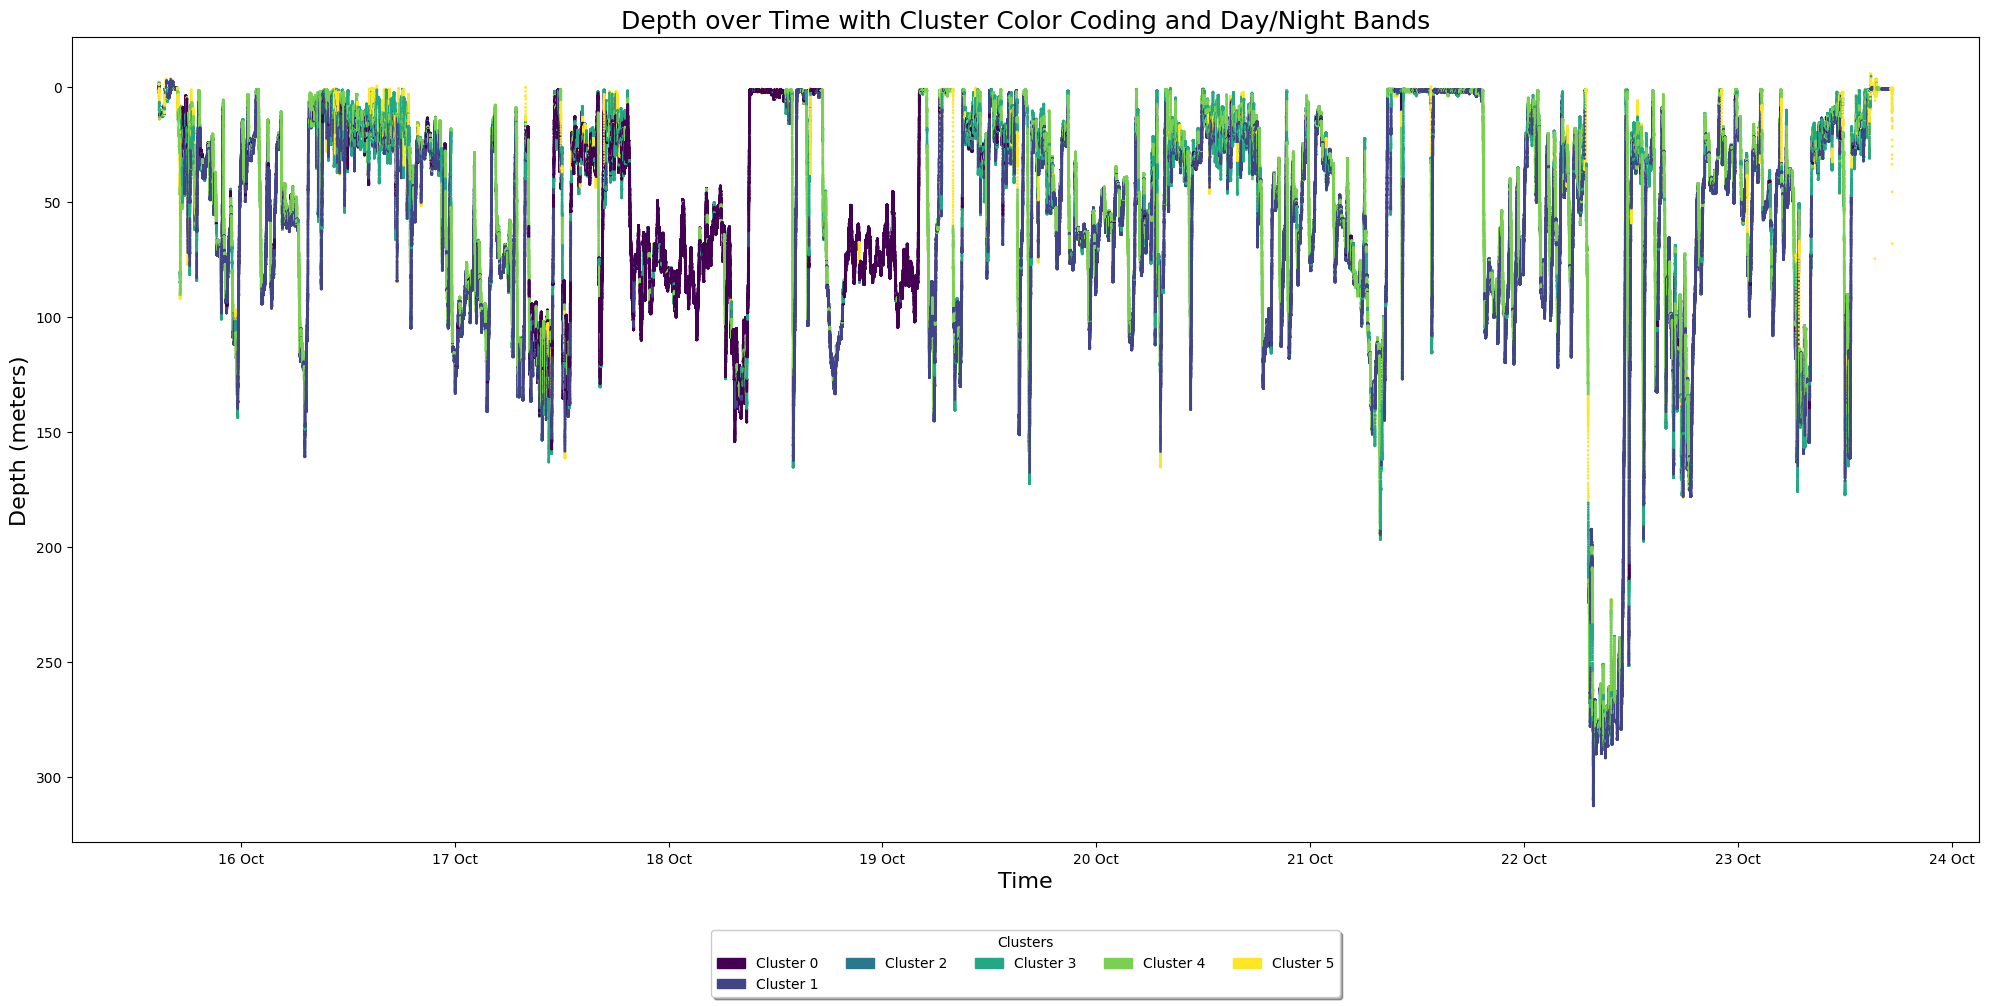

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

# Assuming 'n_clusters' is the number of clusters you determined with KMeans
n_clusters = len(data_processed['cluster'].unique())

# Set plot titles and labels
plt.figure(figsize=(20, 10))
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (meters)', fontsize=16)
plt.title('Depth over Time with Cluster Color Coding and Day/Night Bands', fontsize=18)

# Plot day-night bands
# Ensure 'sun_cycles' is defined and formatted correctly
# plot_day_night_bands(sun_cycles, plt.gca())

# Use a predefined colormap for clusters
cmap = plt.cm.get_cmap('viridis', n_clusters)

# Create a list of patches for the legend
cluster_patches = [mpatches.Patch(color=cmap(i/n_clusters), label=f'Cluster {i}') for i in range(n_clusters)]

# Plot depth data against time, colored by cluster
# Use DataFrame index directly for the time values
sc = plt.scatter(data_processed.index, data_processed['Pressure'], c=data_processed['cluster'], cmap=cmap, s=1, alpha=0.9)

# Make increased depth down
plt.gca().invert_yaxis()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Position the legend under the graph
plt.legend(handles=cluster_patches, title='Clusters', loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

# Increase the bottom margin to ensure the legend does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.25)

# Show the plot
plt.tight_layout()
plt.show()
